In [1]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image
from torchvision import transforms, datasets

import adain.net as net

from styleclr.test import test_transform, style_transfer
from styleclr.utils import move_to_top_directory
from styleclr.dataset import ContrastiveLearningDataset


In [2]:
move_to_top_directory()
%pwd

'/home/felix/styleclr'

In [3]:
output_path = Path('output')
decoder_path = Path('adain/models/decoder.pth')
vgg_path = Path('adain/models/vgg_normalised.pth')
content_size = 512
style_size = 512
crop = False
alpha = 1
save_ext = '.jpg'

content_path = Path('adain/input/content/avril.jpg')
style_path = Path('adain/input/style/asheville.jpg')

dataset_path = Path('datasets')
dataset_name = 'stl10'
n_views = 2
batch_size = 4
workers = 32

In [4]:
style_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])
style_dataset = datasets.ImageFolder(root='datasets/wikiart', transform=style_transform)
style_dataloader = torch.utils.data.DataLoader(style_dataset, batch_size=4, shuffle=True, num_workers=4)

In [5]:
dataset = ContrastiveLearningDataset(dataset_path)
train_dataset = dataset.get_dataset(dataset_name, n_views)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True, drop_last=True)

Files already downloaded and verified


/home/felix/anaconda3/envs/styleclr/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
content_image = next(iter(train_loader))[0][0][0]
style_image = next(iter(style_dataloader))[0][0]

toPIL = transforms.ToPILImage()

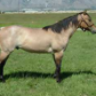

In [13]:
toPIL(content_image)

content_

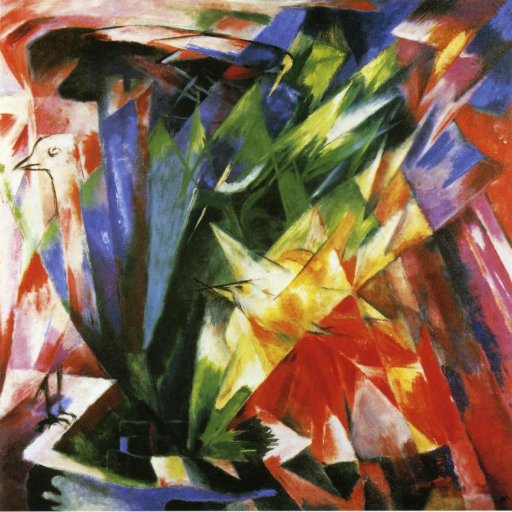

In [14]:
toPIL(style_image)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

decoder = net.decoder
vgg = net.vgg

decoder.eval()
vgg.eval()

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))
vgg = nn.Sequential(*list(vgg.children())[:31])

vgg.to(device)
decoder.to(device)

content_tf = test_transform(content_size, crop)
style_tf = test_transform(style_size, crop)

/home/felix/anaconda3/envs/styleclr/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


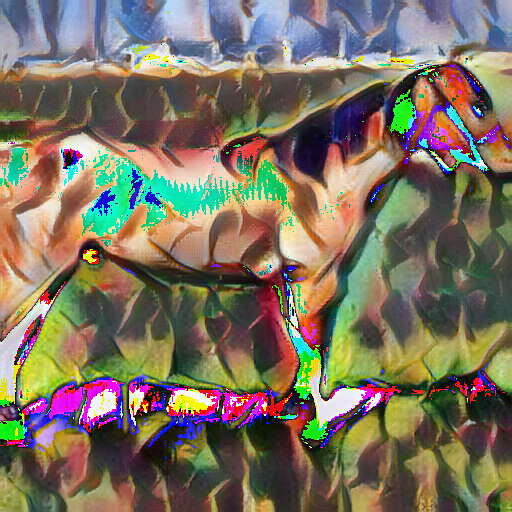

In [16]:
content = content_tf(toPIL(content_image))
style = style_tf(toPIL(style_image))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)

with torch.no_grad():
    output = style_transfer(device, vgg, decoder, content, style, alpha)
output = output.cpu()

toPIL(output[0])